In [1]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt 

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn


from pytvision.transforms.aumentation import  ObjectImageMetadataTransform
from pytvision.transforms import transforms as mtrans

sys.path.append('../')
from torchlib.datasets import tgsdata
from torchlib.datasets.tgsdata import TGSDataset
from torchlib.segneuralnet import SegmentationNeuralNet
from torchlib.transforms import functional as F
from torchlib.utility import rle_encode, sigmoid
from torchlib.metrics import intersection_over_union, intersection_over_union_thresholds
from torchlib.metrics import compute_ious


## CONFIGURATE

In [3]:
!ls ../netruns/

exp_tgs_dunet_mcedice_adam_tgs-salt-identification-challenge_001
exp_tgs_unet11_mcedice_adam_tgs-salt-identification-challenge_001
exp_tgs_unet_mcedice_adam_tgs-salt-identification-challenge_001
exp_tgs_unetresnet_152_mcedice_adam_tgs-salt-identification-challenge_001
exp_tgs_unetresnet_mcedice_adam_tgs-salt-identification-challenge_001
exp_tgs_unetresnet_mcedice_adam_tgs-salt-identification-challenge_002


In [2]:
project          = '../netruns'
name             = 'exp_tgs_unetresnet_152_mcedice_adam_tgs-salt-identification-challenge_001'
pathnamedataset  = '~/.kaggle/competitions/tgs-salt-identification-challenge'
pathmodel        = os.path.join( project, name, 'models/chk000628.pth.tar' )
batch_size       = 2
workers          = 1
cuda             = False
parallel         = False
gpu              = 1
seed             = 1
imsize           = 101


## DATASET

In [32]:
# Load dataset
print('>> Load dataset ...')

dataset = TGSDataset(  
    pathnamedataset, 
    'train', 
    num_channels=3,
    train=True, 
    files='train.csv',
    transform=transforms.Compose([
        mtrans.ToResize( (256,256), resize_mode='squash', padding_mode=cv2.BORDER_REFLECT_101 ),
        #mtrans.ToResizeUNetFoV(imsize, cv2.BORDER_REFLECT_101),
        mtrans.ToTensor(),
        #mtrans.ToNormalization(), 
        mtrans.ToMeanNormalization( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], )
        ])
    )

print(len(dataset))

>> Load dataset ...
4000


## LOAD MODEL

In [5]:
# load model
print('>> Load model ...')

net = SegmentationNeuralNet( 
    patchproject=project, 
    nameproject=name, 
    no_cuda=cuda, 
    parallel=parallel, 
    seed=seed, 
    gpu=gpu 
    )

if net.load( pathmodel ) is not True:
    assert(False)

>> Load model ...
=> loading checkpoint '../netruns/exp_tgs_unetresnet_152_mcedice_adam_tgs-salt-identification-challenge_001/models/chk000628.pth.tar'
=> loaded checkpoint for unetresnet arch!


## TTA

torch.Size([1, 3, 256, 256])


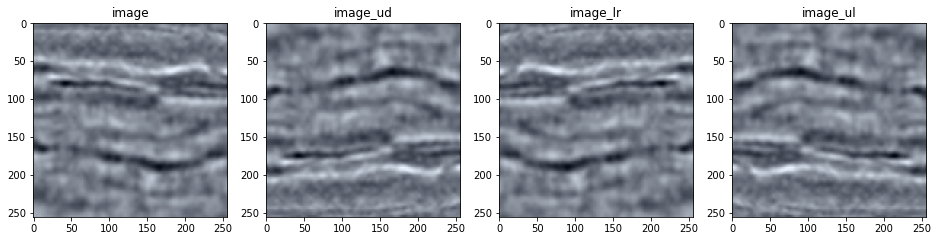

In [5]:
def norm(x):
    x = x-x.min()
    x = x / x.max()
    return x

sample   = dataset[ 0 ]
image    = sample['image'].unsqueeze(0)
print(image.shape)

image_ud = F.flipud( image )
image_lr = F.fliplr( image )
image_ul = F.flipud( F.fliplr( image ) )

image    = image.data.cpu().numpy().transpose(2,3,1,0)[...,0]
image_ud = image_ud.data.cpu().numpy().transpose(2,3,1,0)[...,0]
image_lr = image_lr.data.cpu().numpy().transpose(2,3,1,0)[...,0]
image_ul = image_ul.data.cpu().numpy().transpose(2,3,1,0)[...,0]


plt.figure( figsize=(16,8))
plt.subplot(141)
plt.imshow( norm(image) )
plt.title('image')
plt.subplot(142)
plt.imshow( norm(image_ud) )
plt.title('image_ud')
plt.subplot(143)
plt.imshow( norm(image_lr) )
plt.title('image_lr')
plt.subplot(144)
plt.imshow( norm(image_ul) )
plt.title('image_ul')
plt.show()


## METADATA

In [33]:
from PIL import Image
from PIL.ExifTags import TAGS
import png

def norm(x):
    x = x-x.min()
    x = x / x.max()
    return x

def get_exif(fn):
    ret = {}
    i = Image.open(fn)
    info = i._getexif()
    for tag, value in info.items():
        decoded = TAGS.get(tag, tag)
        ret[decoded] = value
    return ret


im_data = []
mk_data = []
for i in range( len(dataset) ):

    sample    = dataset[ i ]
    path_name = dataset.data.data[0][1]
    # print(path_name)

    image = sample['image'].data.cpu().numpy().transpose(1,2,0)
    label = sample['label'].data.cpu().numpy().transpose(1,2,0)[:,:,1]
    #image = norm(image)
    
    im_data.append( image.sum() )
    mk_data.append( label.sum() )
    
    # print(image.shape)
    # print(label.shape)
    


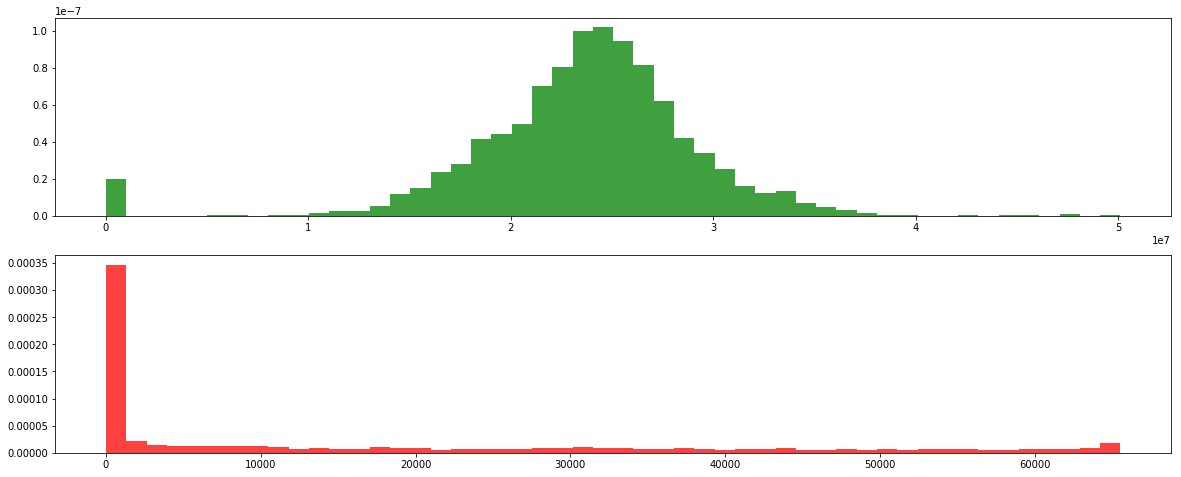

In [34]:


plt.figure( figsize=(20,8) )
plt.subplot(211)
plt.hist( im_data, 50, density=True, facecolor='g', alpha=0.75 )
plt.subplot(212)
plt.hist( mk_data, 50, density=True, facecolor='r', alpha=0.75 )
plt.show()



66 [[0.]]


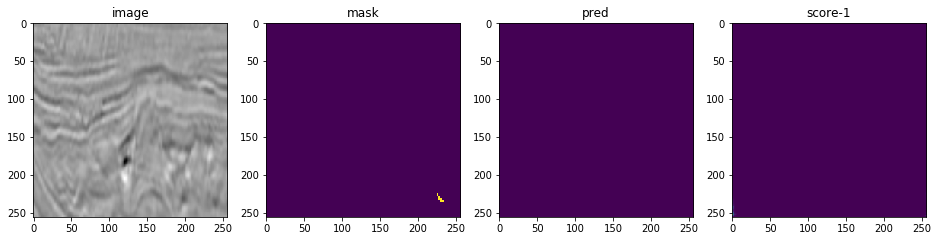

95 [[0.]]


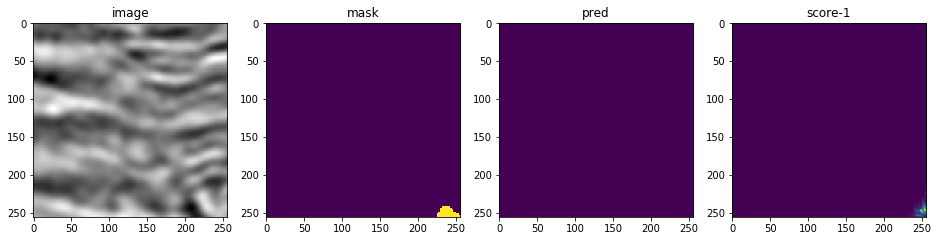

111 [[0.]]


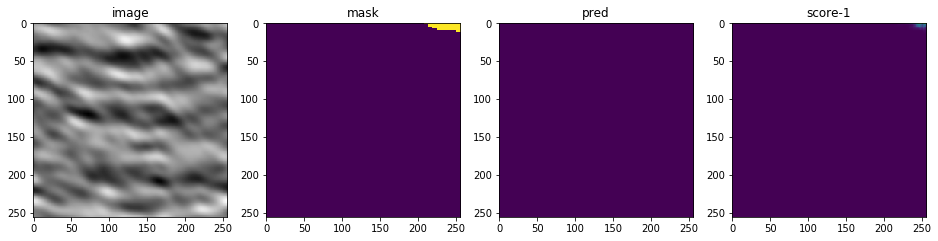

116 [[0.]]


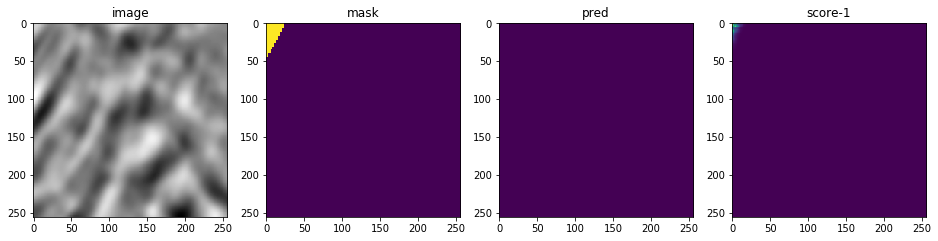

202 [[0.]]


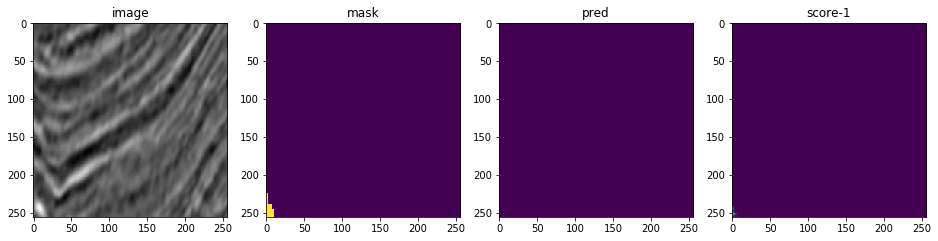

256 [[0.]]


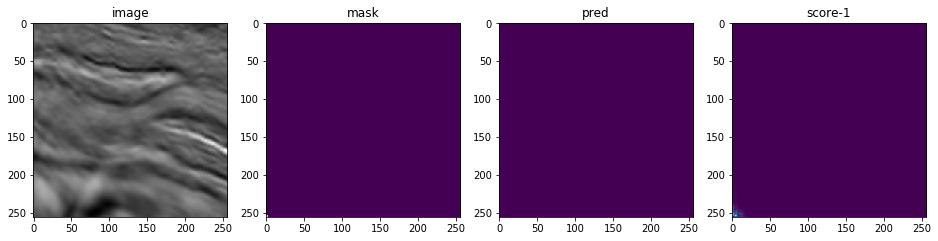

299 [[0.]]


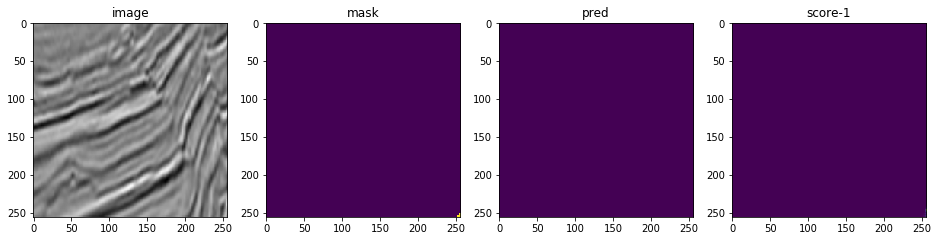

313 [[0.40776699]]


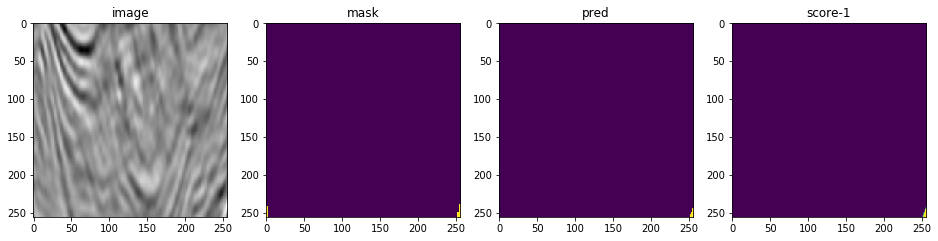

368 [[0.]]


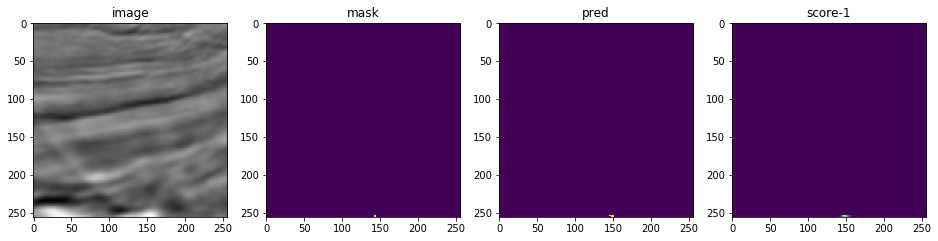

397 [[0.]]


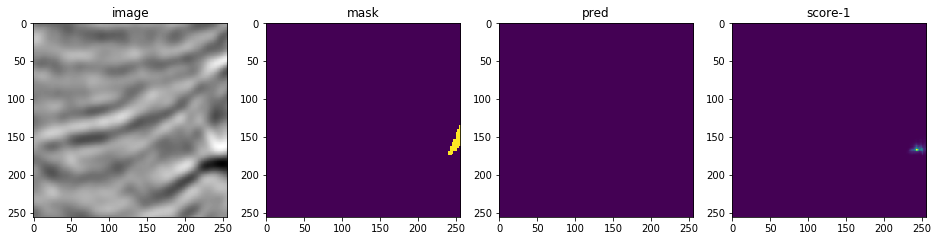

486 [[0.]]


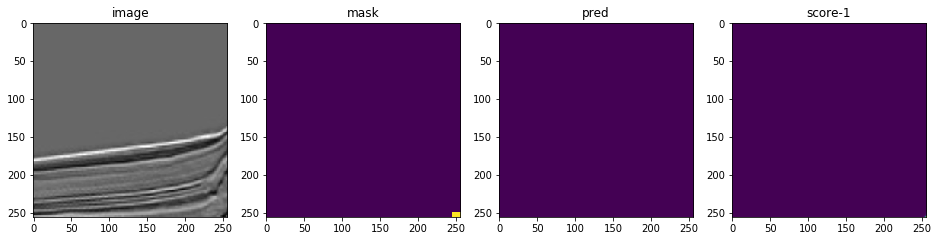

503 [[0.]]


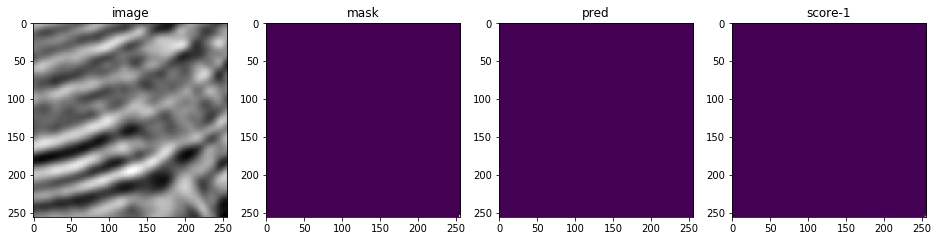

528 [[0.]]


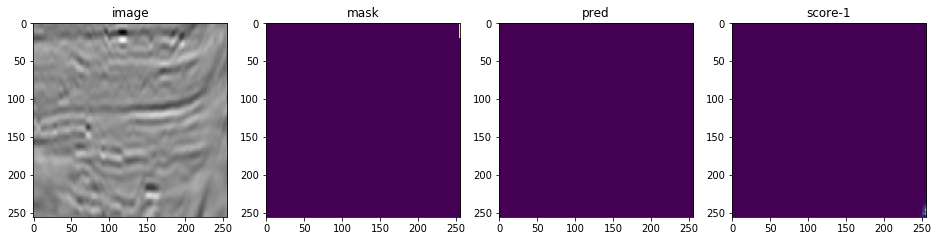

559 [[0.]]


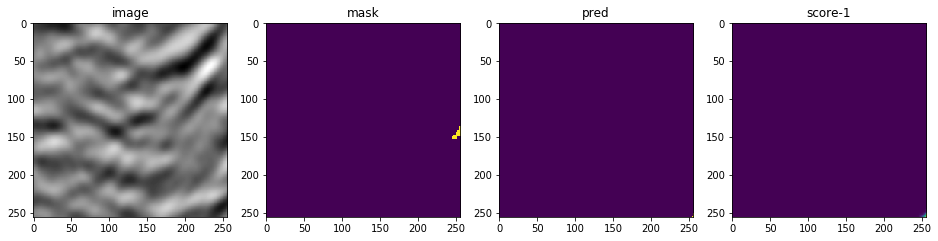

561 [[0.]]


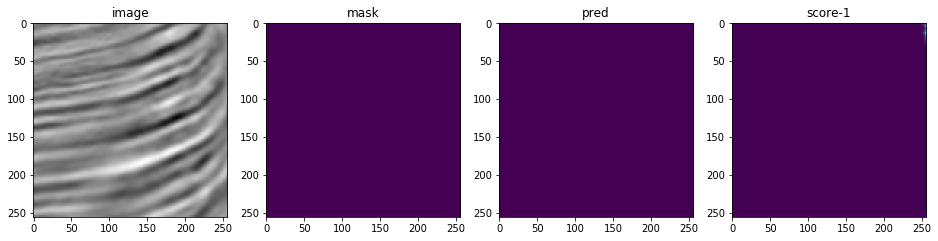

590 [[0.44166667]]


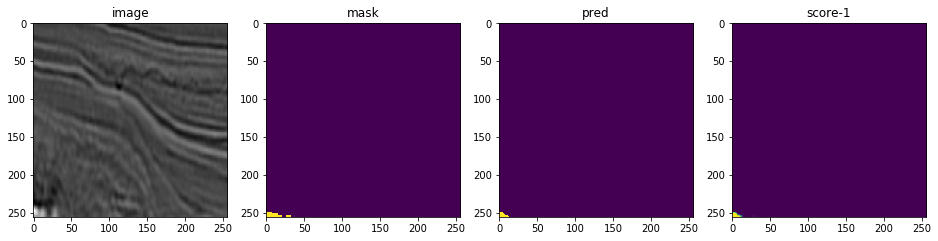

642 [[0.]]


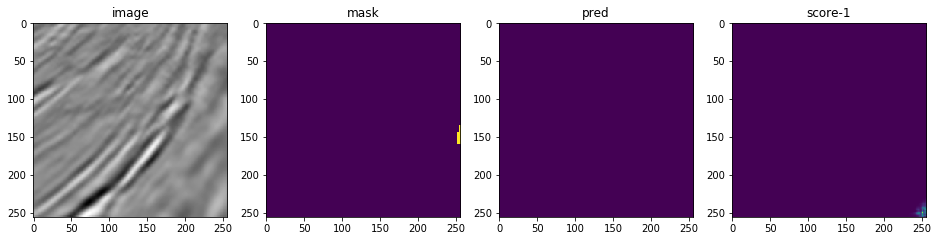

657 [[0.5]]


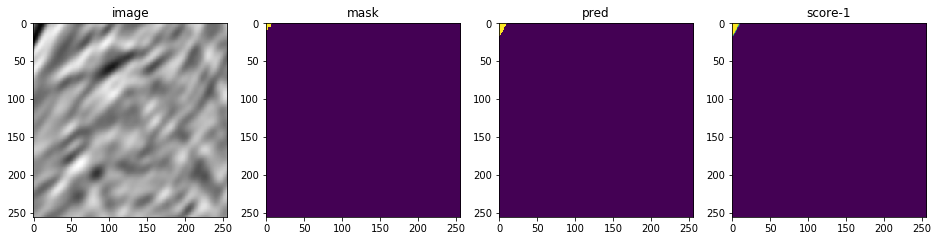

718 [[0.]]


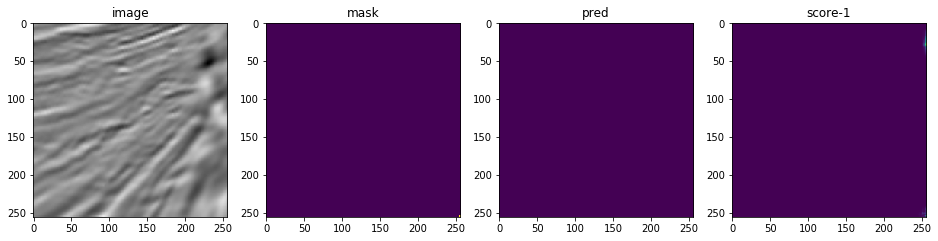

826 [[0.]]


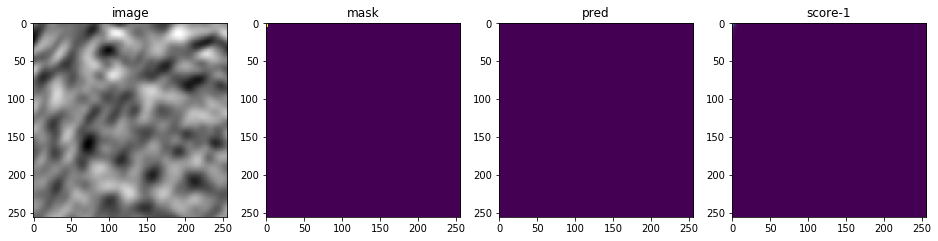

851 [[0.46488294]]


In [9]:


idx=0
k=0
for i in range( len(dataset) ):
    
    idx = i
    sample = dataset[ idx ]    
    mask = sample['label'][1,:,:].data.numpy()
    #mask = mask[92:92+116, 92:92+116]

    idname = dataset.data.getimagename( idx )
    score = net( sample['image'].unsqueeze(0), torch.Tensor( [0] ) ).float()
    score = score.data.cpu().numpy().transpose(2,3,1,0)[...,0]

    #score = F.resize_unet_inv_transform( score, (101,101,3), 101, cv2.INTER_CUBIC )
    #mask  = F.resize_unet_inv_transform( mask , (101,101,3), 101, cv2.INTER_LINEAR )

    pred  = np.argmax( score, axis=2 )
    #pred  = sigmoid( score[:,:,1] ) > 0.65 
    #print(score.shape)
    
    if mask.sum() < 1:
        continue
    
    iou = compute_ious(mask.astype(int), pred.astype(int))   
    if iou > 0.5: continue
    print(idx, iou)
    
    k+=1    
    if k > 20:
        break

    plt.figure( figsize=(16,8))
    plt.subplot(141)
    plt.imshow(sample['image'][0,:,:], cmap='gray')
    plt.title('image')
    plt.subplot(142)
    plt.imshow(mask)
    plt.title('mask')
    plt.subplot(143)
    plt.imshow(pred)
    plt.title('pred')
    plt.subplot(144)
    plt.imshow(score[:,:,1])
    plt.title('score-1')
    plt.show()
